In [1]:
# heavy imports

from diffusers import AutoencoderKL
from diffusers import DDPMScheduler
from diffusers import StableDiffusionPipeline
from diffusers import UNet2DConditionModel

In [2]:
import os
import math
import random
import json
import numpy as np
import csv

import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from typing import Optional
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.transforms import functional as TF
from datasets import load_dataset, Dataset

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import get_constant_schedule_with_warmup

# Import Accelerate
from accelerate import Accelerator
from accelerate.utils import set_seed

In [3]:
# setup

SEED = 42
set_seed(SEED)  # Using accelerate's set_seed function

# Initialize accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="fp16",  # Use mixed precision for faster training
    log_with="tensorboard",
    project_dir="./logs"
)

# Import torch.compile if available (PyTorch 2.0+)
compile_unet = False
if hasattr(torch, 'compile'):
    compile_unet = True
    print("PyTorch 2.0+ detected - will use torch.compile")

# Print accelerator state
print(f"Distributed: {accelerator.distributed_type}")
print(f"Mixed Precision: {accelerator.mixed_precision}")

# Check if GPUs are available with accelerate
device = accelerator.device
print(f"Using device: {device}")

# gpu details: preferred A100 with 256 GBs
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
    
print("No. of CPU cores:", os.cpu_count())

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Distributed: NO
Mixed Precision: fp16
Using device: cuda
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
No. of CPU cores: 128


In [4]:
# model paths
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"  # base model
output_dir = "./fashion-model-finetuned_t00"  # where to save the model

# dataset parameters
base_dir = 'data/DFMM-Spotlight/'  # data path
image_column = "image"  # column name containing images
caption_column = "text"  # column name containing captions
train_images_dir = os.path.join(base_dir, "train_images")
mask_dir = os.path.join(base_dir, "mask")
ann_file = os.path.join(base_dir, "mask_ann", "train_ann_file.jsonl")

# Create a CSV file for loss logging
loss_log_file = os.path.join(output_dir, "training_loss.csv")
os.makedirs(output_dir, exist_ok=True)
with open(loss_log_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['step', 'epoch', 'loss'])  # Header

In [5]:
# training parameters
resolution = 512  # image resolution for training
train_batch_size = 8  # adjust based on your gpu memory, i set because of 80GB GPUs
num_train_epochs = 10  # number of training epochs
max_train_steps = None  # if set, overrides num_train_epochs
gradient_accumulation_steps = 1  # for effective larger batch size
learning_rate = 1e-5  # training learning rate
lr_scheduler = "cosine"  # learning rate scheduler type
lr_warmup_steps = 1000  # warmup steps for learning rate
adam_beta1 = 0.9  # adam optimizer beta1
adam_beta2 = 0.999  # adam optimizer beta2
adam_weight_decay = 1e-2  # weight decay for regularization
adam_epsilon = 1e-08  # small epsilon for numerical stability
max_grad_norm = 1.0  # gradient clipping norm
checkpointing_steps = 5000  # save checkpoint every n steps

# Enable gradient checkpointing for memory efficiency
enable_gradient_checkpointing = True

In [6]:
# noise scheduler for the diffusion process
noise_scheduler = DDPMScheduler.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="scheduler"
)

# tokenizer for processing text prompts
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="tokenizer"
)

# text encoder to convert text to embeddings
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="text_encoder"
)

# vae model for encoding images to latent space and vice versa
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="vae"
)

# unet model - the part we'll be fine-tuning
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path,
    low_cpu_mem_usage=False, 
    ignore_mismatched_sizes=True,
    in_channels=9,  # modified for mask and masked image
    subfolder="unet"
)

# Enable gradient checkpointing and compile if available
if enable_gradient_checkpointing:
    unet.enable_gradient_checkpointing()

# Compile the model if available (PyTorch 2.0+)
if compile_unet:
    print("Compiling UNet model...")
    unet = torch.compile(unet)
    
# freeze vae and text encoder - we only want to train the UNet
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

# print model parameters information
print(f"UNet parameters to be trained: {sum(p.numel() for p in unet.parameters() if p.requires_grad)}")

/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of UNet2DConditionModel were not initialized from the model checkpoint at runwayml/stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 9, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


UNet parameters to be trained: 859535364


In [7]:
# Load the annotation lines
with open(ann_file, "r") as f:
    lines = [json.loads(line.strip()) for line in f]
    
random.shuffle(lines)

# Create data entries with full paths and loadable objects
data = []
for entry in tqdm(lines):  # subquering for testing
    image_path = os.path.join(train_images_dir, entry["image"])
    mask_path = os.path.join(mask_dir, entry["mask"])
    
    if os.path.exists(image_path) and os.path.exists(mask_path):
        data.append({
            "image_path": image_path,
            "mask_path": mask_path,
            "image": Image.open(image_path),
            "mask": Image.open(mask_path),
            "text": entry["text"]
        })
    else:
        print(f"Missing file for {entry['image']} or {entry['mask']}")

# Create HuggingFace dataset
train_dataset = Dataset.from_list(data)

print(train_dataset)

  0%|          | 0/21377 [00:00<?, ?it/s]

Dataset({
    features: ['image_path', 'mask_path', 'image', 'mask', 'text'],
    num_rows: 21377
})


In [8]:
def joint_transform(image, mask, resolution):
    # Resize image and mask
    image = TF.resize(image, size=(resolution, resolution // 2), interpolation=TF.InterpolationMode.BILINEAR)
    mask = TF.resize(mask, size=(resolution, resolution // 2), interpolation=TF.InterpolationMode.NEAREST)

    # Center crop both
    image = TF.center_crop(image, output_size=[resolution, resolution])
    mask = TF.center_crop(mask, output_size=[resolution, resolution])

    # Random horizontal flip
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # To tensor
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])
    mask = TF.to_tensor(mask)

    return image, mask

In [9]:
# preprocessing function
def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]  # convert images to RGB format
    masks = [mask for mask in examples['mask']]  # extract masks (assumes dataset has a 'mask' column)
    
    examples["pixel_values"] = []
    examples["pixel_mask_values"] = []

    for img, mask in zip(images, masks):
        img_t, mask_t = joint_transform(img, mask, resolution)
        examples["pixel_values"].append(img_t)
        examples["pixel_mask_values"].append(mask_t)
    
    # create masked pixel values by applying mask to image
    examples["masked_pixel_values"] = [
        torch.masked_fill(
            examples["pixel_values"][i], 
            examples["pixel_mask_values"][i].bool(), 
            0
        ) for i in range(len(images))
    ]
    
    # tokenize the captions
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            captions.append(random.choice(caption))
        else:
            raise ValueError("Caption column should contain strings or lists of strings.")
            
    inputs = tokenizer(
        captions, 
        max_length=tokenizer.model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    examples["input_ids"] = inputs.input_ids
    
    return examples

# apply preprocessing to the dataset
train_dataset = train_dataset.with_transform(preprocess_train)

Parameter 'transform'=<function preprocess_train at 0x7f9b26378d30> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [10]:
# collate function for the dataloader
def collate_fn(examples):
    # stack the tensors
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()    
    pixel_mask_values = torch.stack([example["pixel_mask_values"] for example in examples])
    pixel_mask_values = pixel_mask_values.to(memory_format=torch.contiguous_format)
    masked_pixel_values = torch.stack([example["masked_pixel_values"] for example in examples])
    masked_pixel_values = masked_pixel_values.to(memory_format=torch.contiguous_format).float()
    
    # stack the tokenized text
    input_ids = torch.stack([example["input_ids"] for example in examples])
    
    return {
        "pixel_values": pixel_values, 
        "pixel_mask_values": pixel_mask_values,
        "masked_pixel_values": masked_pixel_values, 
        "input_ids": input_ids
    }

# create DataLoader for training
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
    num_workers=16,  # adjust based on your CPU (can be found out using os.cpu_count())
    pin_memory=True,  # Speeds up host to device transfers
)

/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# set up optimizer for the unet model
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

# number of steps for training
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)

if max_train_steps is None:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
    
# create learning rate scheduler
lr_scheduler = get_constant_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps
)

# Prepare models, optimizer, dataloader, and lr_scheduler with accelerator
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# Move VAE and text encoder to device and make sure they're in eval mode
vae.to(accelerator.device).eval()
text_encoder.to(accelerator.device).eval()

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, ele

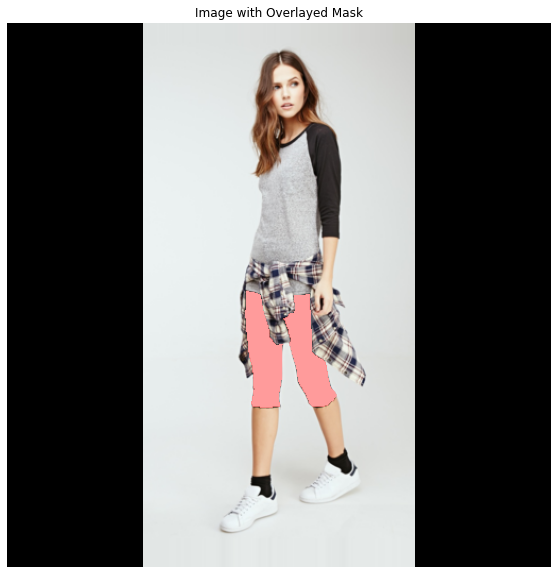

Caption Token IDs: tensor([49406,  2097,   268,  6632, 13606,  1449, 23172, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407], device='cuda:0')


In [12]:
# Get a batch
batch = next(iter(train_dataloader))

# Select the first image and mask from batch
img_tensor = batch['pixel_values'][0]
mask_tensor = batch['pixel_mask_values'][0]

# Unnormalize image tensor and convert to PIL
img_pil = TF.to_pil_image((img_tensor * 0.5 + 0.5).clamp(0, 1))

# Convert mask to a binary mask image (0 or 255)
mask_pil = TF.to_pil_image(mask_tensor).convert("L")  # "L" mode for grayscale

# Optionally: apply a color to the mask
mask_colored = Image.new("RGBA", mask_pil.size, color=(255, 0, 0, 100))  # Red with alpha
mask_binary = mask_pil.point(lambda x: 255 if x > 0 else 0).convert("1")  # binary mask

# Paste the red mask over the image using binary mask as alpha mask
img_overlay = img_pil.convert("RGBA").copy()
img_overlay.paste(mask_colored, mask=mask_binary)

# Display overlay
plt.figure(figsize=(10, 10))
plt.imshow(img_overlay)
plt.title("Image with Overlayed Mask")
plt.axis('off')
plt.show()

# Optional: print caption token IDs
print("Caption Token IDs:", batch['input_ids'][0])

In [13]:
# Function to log losses to CSV
def log_loss_to_csv(step, epoch, loss):
    with open(loss_log_file, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([step, epoch, loss])

# Start training
global_step = 0
progress_bar = tqdm(range(max_train_steps), desc="Training Steps")

for epoch in range(num_train_epochs):
    print(f"\nEpoch {epoch+1}/{num_train_epochs}")
    unet.train()
    train_loss = 0.0
    
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):  # Handles gradient accumulation automatically
            # Use VAE to encode images to latent space
            with torch.no_grad():
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                
                # encode the masked images
                masked_latents = vae.encode(batch["masked_pixel_values"]).latent_dist.sample()
                masked_latents = masked_latents * vae.config.scaling_factor
                
                # resize mask to match latent resolution
                mask = F.interpolate(
                    batch["pixel_mask_values"],
                    size=(resolution // 8, resolution // 8),  # Match aspect ratio
                    mode='nearest'
                )
                
                # Get text embeddings for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]
            
            # Sample noise for diffusion
            noise = torch.randn_like(latents)
            
            # Sample random timesteps for diffusion process
            bsz = latents.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device
            ).long()
            
            # add noise to latents according to noise schedule (forward diffusion)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # concatenate the inputs for the unet
            latent_model_input = torch.cat([noisy_latents, mask, masked_latents], dim=1)
            
            # determine the target for loss calculation based on prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise  # predict the noise that was added
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            
            # forward pass through unet to predict noise
            model_output = unet(
                latent_model_input, 
                timesteps, 
                encoder_hidden_states
            )
            
            model_pred = model_output.sample  # NOT .sample()
            
            # calculate loss between prediction and target
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            
            # Accelerator handles backward pass
            accelerator.backward(loss)
            
            # Only clip grad norm if not using gradient accumulation
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), max_grad_norm)
                
            # Step optimizer and scheduler if we are accumulating gradients
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
                
        # Wait for all processes to sync
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            
            # Log loss
            if global_step % 1000 == 0:  # Increased frequency of logging
                accelerator.print(f"Step {global_step}: Loss: {loss.detach().item():.5f}")
                # Log to CSV
                log_loss_to_csv(global_step, epoch+1, loss.detach().item())
            
            # Save checkpoint
            if global_step % checkpointing_steps == 0:
                accelerator.print(f"Saving checkpoint at step {global_step}")
                
                # Wait for all processes
                accelerator.wait_for_everyone()
                
                # Get unwrapped model for saving
                unwrapped_unet = accelerator.unwrap_model(unet)
                
                # Save with accelerator to handle distributed setup
                accelerator.save_state(output_dir=os.path.join(output_dir, f"checkpoint-{global_step}"))
                
                # Also save the unwrapped unet
                if accelerator.is_main_process:
                    unwrapped_unet.save_pretrained(os.path.join(output_dir, f"checkpoint-{global_step}", "unet"))
                    
                accelerator.print(f"Saved checkpoint to {os.path.join(output_dir, f'checkpoint-{global_step}')}")
        
        # Check if we've reached max steps
        if global_step >= max_train_steps:
            break
    
    # End of epoch
    accelerator.print(f"Epoch {epoch+1} finished")
    
    # Check if we've reached max steps
    if global_step >= max_train_steps:
        break

# End of training - save the final model
accelerator.print("Training complete!")
accelerator.print(f"Saving final model to {output_dir}")

# Wait for all processes
accelerator.wait_for_everyone()

# Get unwrapped model for saving
unwrapped_unet = accelerator.unwrap_model(unet)

# Save the unet only from the main process
if accelerator.is_main_process:
    unwrapped_unet.save_pretrained(os.path.join(output_dir, "unet"))
    
    # Create and save the full pipeline for inference
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path,
        text_encoder=text_encoder,
        vae=vae,
        unet=unwrapped_unet,
    )
    
    # Save the pipeline
    pipeline.save_pretrained(output_dir)
    accelerator.print(f"Model saved to {output_dir}")

Training Steps:   0%|          | 0/26730 [00:00<?, ?it/s]


Epoch 1/10


/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Step 1000: Loss: 0.01985
Step 2000: Loss: 0.01376
Epoch 1 finished

Epoch 2/10
Step 3000: Loss: 0.01015
Step 4000: Loss: 0.01486
Step 5000: Loss: 0.02784
Saving checkpoint at step 5000
Saved checkpoint to ./fashion-model-finetuned_t00/checkpoint-5000
Epoch 2 finished

Epoch 3/10
Step 6000: Loss: 0.02290
Step 7000: Loss: 0.01431
Step 8000: Loss: 0.00989
Epoch 3 finished

Epoch 4/10
Step 9000: Loss: 0.01522
Step 10000: Loss: 0.01409
Saving checkpoint at step 10000
Saved checkpoint to ./fashion-model-finetuned_t00/checkpoint-10000
Epoch 4 finished

Epoch 5/10
Step 11000: Loss: 0.01449
Step 12000: Loss: 0.01262
Step 13000: Loss: 0.01750
Epoch 5 finished

Epoch 6/10
Step 14000: Loss: 0.01042
Step 15000: Loss: 0.01592
Saving checkpoint at step 15000
Saved checkpoint to ./fashion-model-finetuned_t00/checkpoint-15000
Step 16000: Loss: 0.00493
Epoch 6 finished

Epoch 7/10
Step 17000: Loss: 0.01325
Step 18000: Loss: 0.01037
Epoch 7 finished

Epoch 8/10
Step 19000: Loss: 0.01043
Step 20000: Loss:

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Model saved to ./fashion-model-finetuned_t00
